In [ ]:
# link colab to google drive directory where this project data is placed
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import numpy as np
import tensorflow as tf
print(tf.__version__)


# set project path
projectpath = "/content/gdrive/My Drive/GraphAttnProject/ErdosRanyiSubmission/"

print(projectpath)
#print(datareadpath)



%cd  /content/gdrive/My Drive/GraphAttnProject/ErdosRanyiSubmission/

!pip install dgl




Mounted at /content/gdrive
2.4.1
/content/gdrive/My Drive/GraphAttnProject/ErdosRanyiSubmission/
/content/gdrive/My Drive/GraphAttnProject/ErdosRanyiSubmission
     |████████████████████████████████| 4.4MB 4.0MB/s 


In [ ]:
import os
os.chdir(projectpath)
os.getcwd()

'/content/gdrive/My Drive/GraphAttnProject/ErdosRanyiSubmission'

In [ ]:
from CodeZip_ER import *

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


# Caveman Graph

In [ ]:
name = 'CircularLadder'

num_train = 768
num_val =  256
num_test =  256

In [ ]:
if name == 'Caveman':
  p_base_er = 0.027
  p_combine = 0.004
  m = 0
elif name == 'Cycle':
  p_base_er = 0.018
  p_combine = 0.004
  m = 1
elif name == 'Grid':   
  p_base_er = 0.026666
  p_combine = 0.004
  m = 3
elif name == 'Ladder':
  p_base_er = 0.026
  p_combine = 0.004
  m = 4
elif name == 'CircularLadder':
  p_base_er = 0.03
  p_combine = 0.004
  m = 5



train generation



positive train


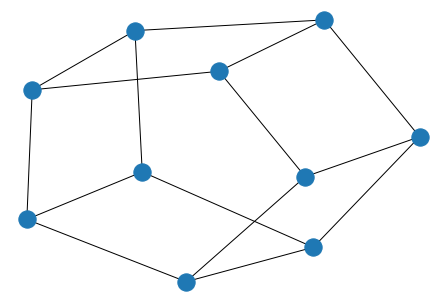

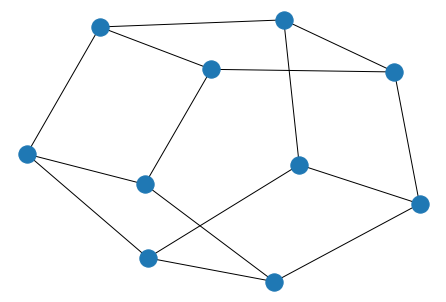

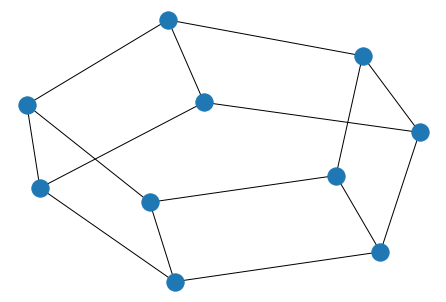

negative train



val generation


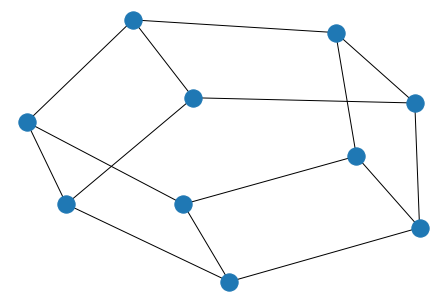

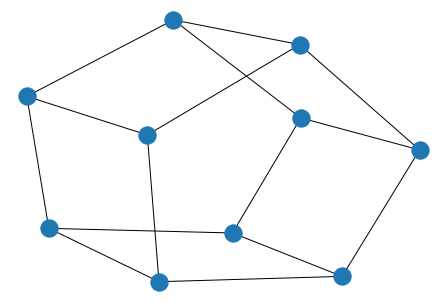


Start generating GAT masking


In [ ]:
info = generate_graphs_labels_ER(m=m, n_min = 100, n_max =101, num_train = num_train, num_val = num_val, num_test = num_test, p_base_er = p_base_er, p_combine = p_combine, all_connected1 = False, all_connected2 = True)

#GWK_masking = generate_masking_GWK(all_train_graphs_shuffled, all_val_graphs_shuffled, all_test_graphs_shuffled, path_length, num_random_walk, stopping_prob, p, q)
GAT_masking = generate_masking_GAT(info[0], info[2], info[4])
  
train_graphs, train_labels, val_graphs, val_labels, test_graphs, test_labels = info


In [ ]:
# save random walk lists as pickle file
a_file = open(f"graph_data/{name}/train_graphs.pkl", "wb")
pickle.dump(train_graphs, a_file)
a_file.close()

a_file = open(f"graph_data/{name}/val_graphs.pkl", "wb")
pickle.dump(val_graphs, a_file)
a_file.close()

with open(f"graph_data/{name}/train_labels.npy", 'wb') as f:
    np.save(f, train_labels)
with open(f"graph_data/{name}/val_labels.npy", 'wb') as f:
    np.save(f, val_labels)


### generate random walks

In [ ]:
# generate random walks for GKAT

from deepwalk import OnlyWalk

path_length = 5
num_random_walk= 50



def generate_walks_GKAT(graphs, num_random_walk, path_length, stopping_prob = 0.0, p=1, q=1, ignore_start = False):

  walks = []
  
  print('Start generating GWK masking')
  print("walk length = ", path_length)
  print("number of random walks = ", num_random_walk)

  for i in tqdm(range(len(graphs))):
      
      graph = (graphs[i])
      n2v = OnlyWalk.Node2vec_onlywalk(graph = graph, path_length=path_length, num_paths=num_random_walk, p=p, q=q, stop_prob = stopping_prob, with_freq_mat = True)
      walks.append(n2v.walker.walks_dict)

  return walks


In [ ]:
# start random walks
GKAT_walks_train = generate_walks_GKAT(train_graphs, path_length = path_length, num_random_walk = num_random_walk, stopping_prob = 0, p = 1, q= 1, ignore_start = False)
GKAT_walks_val = generate_walks_GKAT(val_graphs, path_length = path_length, num_random_walk = num_random_walk, stopping_prob = 0, p = 1, q= 1, ignore_start = False)


Start generating GWK masking
walk length =  5
number of random walks =  50



Start generating GWK masking
walk length =  5
number of random walks =  50


In [ ]:
# save random walk lists as pickle file
a_file = open(f"graph_data/{name}/GKAT_walks_dict_train.pkl", "wb")
pickle.dump(GKAT_walks_train, a_file)
a_file.close()

a_file = open(f"graph_data/{name}/GKAT_walks_dict_val.pkl", "wb")
pickle.dump(GKAT_walks_val, a_file)
a_file.close()


In [ ]:
GKAT_walks_train = pickle.load(open(f"graph_data/{name}/GKAT_walks_dict_train.pkl", 'rb'))
GKAT_walks_val = pickle.load(open(f"graph_data/{name}/GKAT_walks_dict_val.pkl", 'rb'))


### generate random walk frequency matrix and GKAT dot product kernel

In [ ]:
def generate_trunc_walks_dict(walks, trunc_len):
  print("generating walks with length = ", trunc_len)
  num_random_walk = len(walks[0][0])
  

  trunc_walks = []

  num_graphs = len(walks)
  for i in range(num_graphs):
    g_dict = {}
    num_nodes = len(walks[i])
    for j in range(num_nodes):
      walklist = []
      for k in range(num_random_walk):
        walklist.append(walks[i][j][k][:trunc_len])
      g_dict[j] = walklist
    trunc_walks.append(g_dict)
  return trunc_walks


In [ ]:

def generate_frequency_matrix_and_masking_GKAT(walks_dict):

  num_graphs = len(walks_dict)
  num_random_walk = len(walks_dict[0][0])
  
  walk_length = len(walks_dict[0][0][0])

  freq_mat_list = []
  dot_kernel_list = []

  for graph in tqdm(walks_dict):

    num_nodes = len(graph)

    freq_mat = np.zeros([num_nodes, num_nodes])

    for key in graph:
      for i in range(num_random_walk):
        for j in range(walk_length):
          freq_mat[int(key),int(graph[key][i][j])] +=1
    freq_mat /= num_random_walk

    dot_prod = np.matmul(freq_mat, np.transpose(freq_mat))

    # divide the dot_prod kernel by the norm of the kernel
    deno = np.matmul(np.diagonal(dot_prod)[:, None], np.transpose(np.diagonal(dot_prod)[:, None]))
    dot_kernel = dot_prod / np.sqrt(deno)  #np.diagonal(dot_prod)[:, None]

    freq_mat_list.append(freq_mat* num_random_walk)
    dot_kernel_list.append(dot_kernel)

  return freq_mat_list, dot_kernel_list




In [ ]:
# generate random walk frequency matrix and GKAT dot product kernel with different random walk lengths
# the generated data are saved also as pickle files

for trunc_len in range(4,5):

  trunc_walks_train = generate_trunc_walks_dict(GKAT_walks_train, trunc_len)
  trunc_walks_val = generate_trunc_walks_dict(GKAT_walks_val, trunc_len)



  freq_mat_list, dot_kernel_list = generate_frequency_matrix_and_masking_GKAT(trunc_walks_train)

  a_file = open(f"graph_data/{name}/GKAT_freq_mats_train_len={trunc_len}.pkl", "wb")
  pickle.dump(freq_mat_list, a_file)
  a_file.close()

  a_file = open(f"graph_data/{name}/GKAT_dot_kernels_train_len={trunc_len}.pkl", "wb")
  pickle.dump(dot_kernel_list, a_file)
  a_file.close()




  freq_mat_list, dot_kernel_list = generate_frequency_matrix_and_masking_GKAT(trunc_walks_val)

  a_file = open(f"graph_data/{name}/GKAT_freq_mats_val_len={trunc_len}.pkl", "wb")
  pickle.dump(freq_mat_list, a_file)
  a_file.close()

  a_file = open(f"graph_data/{name}/GKAT_dot_kernels_val_len={trunc_len}.pkl", "wb")
  pickle.dump(dot_kernel_list, a_file)
  a_file.close()


generating walks with length =  4
generating walks with length =  4


In [ ]:
GAT_masking = generate_masking_GAT(info[0], info[2], info[4])

a_file = open(f"graph_data/{name}/GAT_masking_train.pkl", "wb")
pickle.dump(GAT_masking[0], a_file)
a_file.close()

a_file = open(f"graph_data/{name}/GAT_masking_val.pkl", "wb")
pickle.dump(GAT_masking[1], a_file)
a_file.close()


Start generating GAT masking
